In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torchvision.models import segmentation
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

import time
from PIL import Image
import os
from contextlib import redirect_stdout
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
images_dir = '/kaggle/input/version-2/Stage 2/Stage 2/images'
masks_dir = '/kaggle/input/version-2/Stage 2/Stage 2/masks'
dataset_dir = '/kaggle/input/version-2/Stage 2/Stage 2'

In [3]:
batch_size = 16
lr = 0.0002
num_epochs = 100

val_size = 0.1
test_size = 0.02
train_size = 0.88

In [4]:
class SingleMaskDataset(Dataset):
    def __init__(self, root, transform_images=None, transform_masks=None):
        self.root = root
        self.transform_images = transform_images
        self.transform_masks = transform_masks
        self.image_files, self.mask_files = self._load_files()

    def _load_files(self):
        image_files = []
        mask_files = []

        image_dir = os.path.join(self.root, 'images')
        mask_dir = os.path.join(self.root, 'masks')

        image_names = sorted(os.listdir(image_dir))

        for image_name in image_names:
            if image_name.endswith('.png') or image_name.endswith('.bmp'):
                image_path = os.path.join(image_dir, image_name)
                mask_path = os.path.join(mask_dir, image_name)
                mask_files.append(mask_path)
                image_files.append(image_path)

        return image_files, mask_files

    def __getitem__(self, index):
        image_path = self.image_files[index]
        mask_path = self.mask_files[index]
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_images is not None:
            image = self.transform_images(image)
        if self.transform_masks is not None:
            mask = self.transform_masks(mask)

        return image, mask

    def __len__(self):
        return len(self.image_files)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_images = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

transform_masks = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

if os.path.exists(images_dir + '.DS_Store'):
        os.remove(images_dir + '.DS_Store')
        
if os.path.exists(masks_dir + '.DS_Store'):
        os.remove(masks_dir + '.DS_Store')
        
dataset = SingleMaskDataset(root=dataset_dir, transform_images=transform_images, transform_masks=transform_masks)

In [6]:
all_indices = list(range(len(dataset)))

train_indices, remaining_indices = train_test_split(all_indices, test_size=(val_size + test_size), random_state=42)
test_size_adjusted = test_size / (val_size + test_size)
val_indices, test_indices = train_test_split(remaining_indices, test_size=test_size_adjusted, random_state=42)

print("Length of train indices:", len(train_indices))
print("Length of validation indices:", len(val_indices))
print("Length of test indices:", len(test_indices))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Length of train indices: 3877
Length of validation indices: 440
Length of test indices: 89


In [7]:
model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Conv2d(256, 1, kernel_size=1)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 148MB/s]


In [8]:
def dice_loss_per_image(logits, targets, smooth=1e-6):
    logits = torch.sigmoid(logits)
    
    logits = logits.view(-1)
    targets = targets.view(-1)
    
    intersection = torch.sum(logits * targets)
    union = torch.sum(logits) + torch.sum(targets)
    
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1. - dice

def dice_loss(logits, targets):
    loss = 0
    for logit, target in zip(logits, targets):
        loss += dice_loss_per_image(logit, target)
    
    return loss / len(logits)

def find_optimal_threshold(logits, masks):
    return 0.8

In [9]:
train_loss_list = []
train_iou_list = []
train_precision_list = []
train_recall_list = []
train_f1_score_list = []

val_loss_list = []
val_iou_list = []
val_precision_list = []
val_recall_list = []
val_f1_score_list = []

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    intersection = 0.0
    union = 0.0
    true_positives = 0.0
    false_positives = 0.0
    false_negatives = 0.0
    correct_pixels = 0.0
    total_pixels = 0.0

    model.train()
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        logits = outputs["out"]

        loss = dice_loss(logits, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        threshold = find_optimal_threshold(logits, masks)
        preds = torch.sigmoid(logits) > threshold

        intersection += torch.sum(torch.logical_and(preds, masks)).item()
        union += torch.sum(torch.logical_or(preds, masks)).item()
        true_positives += torch.sum(torch.logical_and(preds, masks)).item()
        false_positives += torch.sum(torch.logical_and(preds == 1, masks == 0)).item()
        false_negatives += torch.sum(torch.logical_and(preds == 0, masks == 1)).item()
        
        correct_pixels += torch.sum(preds == masks).item()
        total_pixels += torch.numel(preds)

    epoch_loss = running_loss / len(train_loader)
    iou = intersection / (union + 1e-6)
    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    pixel_acc = correct_pixels / total_pixels

    train_loss_list.append(epoch_loss)
    train_iou_list.append(iou)
    train_precision_list.append(precision)
    train_recall_list.append(recall)
    train_f1_score_list.append(f1_score)

    model.eval()
    with torch.no_grad():
        intersection_val = 0.0
        union_val = 0.0
        true_positives_val = 0.0
        false_positives_val = 0.0
        false_negatives_val = 0.0
        correct_pixels_val = 0.0
        total_pixels_val = 0.0
        total_val_samples = 0
        total_val_loss = 0.0

        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            val_outputs = model(val_images)
            val_logits = val_outputs["out"]

            val_loss = dice_loss(val_logits, val_masks)
            total_val_loss += val_loss.item() * val_images.size(0)
            total_val_samples += val_images.size(0)

            val_preds = torch.sigmoid(val_logits) > threshold

            intersection_val += torch.sum(torch.logical_and(val_preds, val_masks)).item()
            union_val += torch.sum(torch.logical_or(val_preds, val_masks)).item()
            true_positives_val += torch.sum(torch.logical_and(val_preds, val_masks)).item()
            false_positives_val += torch.sum(torch.logical_and(val_preds == 1, val_masks == 0)).item()
            false_negatives_val += torch.sum(torch.logical_and(val_preds == 0, val_masks == 1)).item()
            
            correct_pixels_val += torch.sum(val_preds == val_masks).item()
            total_pixels_val += torch.numel(val_preds)

        val_loss = total_val_loss / (total_val_samples + 1e-6)
        val_iou = intersection_val / (union_val + 1e-6)
        val_precision = true_positives_val / (true_positives_val + false_positives_val + 1e-6)
        val_recall = true_positives_val / (true_positives_val + false_negatives_val + 1e-6)
        val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-6)
        
        val_pixel_acc = correct_pixels_val / total_pixels_val

        val_loss_list.append(val_loss)
        val_iou_list.append(val_iou)
        val_precision_list.append(val_precision)
        val_recall_list.append(val_recall)
        val_f1_score_list.append(val_f1_score)

        flag = False
        if val_loss < best_val_loss:
            flag = True
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        end_time = time.time()
        epoch_time = end_time - start_time

        if (flag):
            print(f"Epoch [{epoch+1}/{num_epochs}]: {epoch_time:.2f}s | Saved Model\nTrain Loss: {epoch_loss:.4f}, Train IoU: {iou:.4f}, Train Pixel Acc: {pixel_acc:.4f}\nValidation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, Pixel Acc: {val_pixel_acc:.4f}")
        else:
            print(f"Epoch [{epoch+1}/{num_epochs}]: {epoch_time:.2f}s\nTrain Loss: {epoch_loss:.4f}, Train IoU: {iou:.4f}, Train Pixel Acc: {pixel_acc:.4f}\nValidation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, Pixel Acc: {val_pixel_acc:.4f}")
        
        print('===================================================================================================')

Epoch [1/100]: 223.90s | Saved Model
Train Loss: 0.4108, Train IoU: 0.6050, Train Pixel Acc: 0.9215
Validation Loss: 0.2951, Validation IoU: 0.6702, Pixel Acc: 0.9348
Epoch [2/100]: 171.53s | Saved Model
Train Loss: 0.2229, Train IoU: 0.7100, Train Pixel Acc: 0.9490
Validation Loss: 0.1858, Validation IoU: 0.7539, Pixel Acc: 0.9565
Epoch [3/100]: 170.84s
Train Loss: 0.1700, Train IoU: 0.7373, Train Pixel Acc: 0.9550
Validation Loss: 0.1872, Validation IoU: 0.7168, Pixel Acc: 0.9487
Epoch [4/100]: 171.26s | Saved Model
Train Loss: 0.1469, Train IoU: 0.7603, Train Pixel Acc: 0.9590
Validation Loss: 0.1565, Validation IoU: 0.7704, Pixel Acc: 0.9612
Epoch [5/100]: 170.80s
Train Loss: 0.1401, Train IoU: 0.7764, Train Pixel Acc: 0.9622
Validation Loss: 0.1678, Validation IoU: 0.7546, Pixel Acc: 0.9559
Epoch [6/100]: 170.97s | Saved Model
Train Loss: 0.1303, Train IoU: 0.7850, Train Pixel Acc: 0.9635
Validation Loss: 0.1509, Validation IoU: 0.7790, Pixel Acc: 0.9604
Epoch [7/100]: 171.50s | S

NameError: name 'train_pixel_acc_list' is not defined

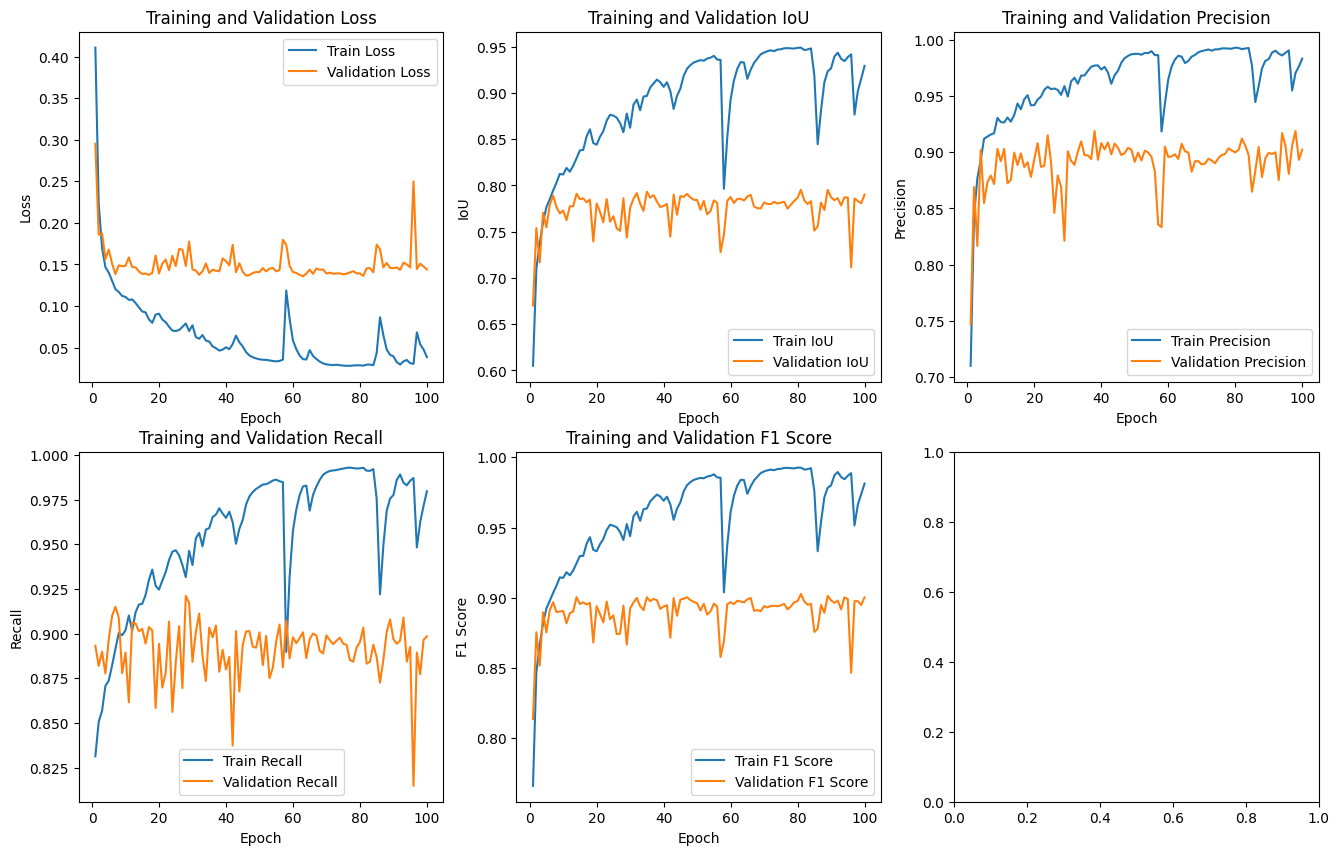

In [10]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_iou_list, label='Train IoU')
plt.plot(epochs, val_iou_list, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, train_precision_list, label='Train Precision')
plt.plot(epochs, val_precision_list, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, train_recall_list, label='Train Recall')
plt.plot(epochs, val_recall_list, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, train_f1_score_list, label='Train F1 Score')
plt.plot(epochs, val_f1_score_list, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(epochs, train_pixel_acc_list, label='Train Pixel Acc')
plt.plot(epochs, val_pixel_acc_list, label='Validation Pixel Acc')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Training and Validation Pixel Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss_list = []
test_iou_list = []
test_pixel_acc_list = []

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    intersection_test = 0.0
    union_test = 0.0
    correct_pixels_test = 0.0
    total_pixels_test = 0.0
    total_test_samples = 0
    total_test_loss = 0.0

    for test_images, test_masks in test_loader:
        test_images = test_images.to(device)
        test_masks = test_masks.to(device, dtype=torch.float)

        test_outputs = model(test_images)
        logits = test_outputs["out"]
        
        test_loss = dice_loss(logits, test_masks)
        total_test_loss += test_loss.item() * test_images.size(0)
        total_test_samples += test_images.size(0)
        
        threshold = find_optimal_threshold(logits, test_masks)
        preds = torch.sigmoid(logits) > threshold

        intersection_test += torch.sum(torch.logical_and(preds, test_masks)).item()
        union_test += torch.sum(torch.logical_or(preds, test_masks)).item()
        
        correct_pixels_test += torch.sum(preds == test_masks).item()
        total_pixels_test += torch.numel(preds)

        test_images_numpy = test_images.cpu().numpy()
        true_masks_numpy = test_masks.cpu().numpy()
        pred_masks_numpy = preds.cpu().numpy()

        for i in range(test_images_numpy.shape[0]):
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(test_images_numpy[i].transpose(1, 2, 0))
            axes[0].set_title("Original Image")
            axes[0].axis("off")

            true_mask = true_masks_numpy[i][0]
            axes[1].imshow(true_mask, cmap='gray')
            axes[1].set_title("True Mask")
            axes[1].axis("off")

            pred_mask = pred_masks_numpy[i][0]
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")

            plt.show()

    test_loss = total_test_loss / (total_test_samples + 1e-6)
    test_iou = intersection_test / (union_test + 1e-6)
    test_pixel_acc = correct_pixels_test / total_pixels_test

    test_loss_list.append(test_loss)
    test_iou_list.append(test_iou)
    test_pixel_acc_list.append(test_pixel_acc)

    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Pixel Acc: {test_pixel_acc:.4f}')
